In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load an audio file and run the DFT on it
import scipy.io.wavfile
path = "../music_recognition/test.wav"
rate, data = scipy.io.wavfile.read(path)
print(rate)

# turn the stereo signal into mono by averaging the channels
data = np.mean(data, axis=1)


44100


In [3]:
# Naive DFT implementation
def dft(x) -> np.ndarray:
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    n = np.arange(N) # Returns a vector of size N with values from 0 to N-1
    k = n.reshape((N, 1)) # Turns the vector into a column vector
    M = np.exp(-2j * np.pi * k * n / N) # Creates the DFT matrix. j is used instead of i.
    return np.dot(M, x) # Multiply the matrix by the signal

def fft(x):
    N = len(x)
    zeros = np.zeros((2**(N-1).bit_length() - N), dtype=complex)
    x = np.concatenate((x, zeros))
    N = len(x)
    
    if N == 1:
        return x
    else:
        X_even = fft(x[::2]) # start at 0 with step size of 2
        X_odd = fft(x[1::2]) # start at 1 with step size of 2

        X = np.zeros(N, dtype=complex)
        for m in range(N):
            m_to_use = m if m < (N//2) else m - (N // 2)
            w_N = np.exp(-2j * np.pi * m / N)
            X[m] = (X_even[m_to_use]) + (np.multiply(w_N, X_odd[m_to_use]))
        return X

In [4]:
import time
def time_dft(x):
    start = time.time()
    dft(x)
    end = time.time()
    return end - start
def time_fft(x):
    start = time.time()
    fft(x)
    end = time.time()
    return end - start

In [5]:
dft_times = []
fft_times = []

lengths_tested = list(range(500, 12_500, 500))
lengths_tested = list(lengths_tested)

for length in lengths_tested:
    print(f"Testing {length=}")
    dft_times.append(time_dft(data[:length]))
    fft_times.append(time_fft(data[:length]))

Testing length=500
Testing length=1000
Testing length=1500
Testing length=2000
Testing length=2500
Testing length=3000
Testing length=3500
Testing length=4000
Testing length=4500
Testing length=5000
Testing length=5500
Testing length=6000
Testing length=6500
Testing length=7000
Testing length=7500
Testing length=8000
Testing length=8500
Testing length=9000
Testing length=9500
Testing length=10000
Testing length=10500
Testing length=11000
Testing length=11500
Testing length=12000


In [6]:
from scipy.optimize import curve_fit

def get_custom_curve_fit(x, y, func):
    """
    Returns params and the coefficient of determination $R^2$
    """

    popt, _ = curve_fit(func, x, y)
    residuals = y - func(x, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return popt, r_squared

def quadratic(x, a, b, c):
    """Quadratic function of the form $ax^2 + bx + c$"""
    return a * (np.power(x, 2)) + (np.multiply(b, x)) + c

def linearithmic(x, a, b):
    """Linearithmic function of the form $ax log_2 x + b"""
    return np.multiply((np.multiply(a, x)), np.log2(x)) + b


In [7]:
dft_params, dft_r_squared = get_custom_curve_fit(lengths_tested, dft_times, quadratic)
fft_params, fft_r_squared = get_custom_curve_fit(lengths_tested, fft_times, linearithmic)
print(f'{dft_params=} {dft_r_squared=}')
print(f'{fft_params=} {fft_r_squared=}')

dft_fit = [quadratic(x, *dft_params) for x in lengths_tested]
fft_fit = [linearithmic(x, *fft_params) for x in lengths_tested]

dft_params=array([ 2.32117990e-08, -5.26392885e-05,  1.07919740e-01]) dft_r_squared=0.9930809636388757
fft_params=array([2.08511221e-06, 3.20184503e-02]) fft_r_squared=0.7990008859731539


In [8]:
get_custom_curve_fit(lengths_tested, fft_times, linearithmic)

(array([2.08511221e-06, 3.20184503e-02]), 0.7990008859731539)

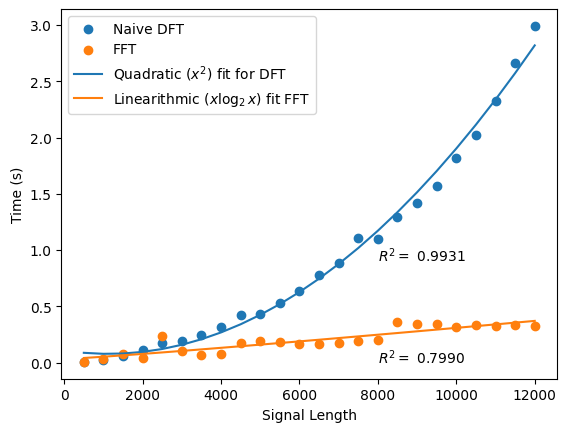

In [9]:
plt.clf()
# Plot the results
plt.scatter(lengths_tested, dft_times, label="Naive DFT")
plt.scatter(lengths_tested, fft_times, label="FFT")

# Plot the line of best fit for each
plt.plot(lengths_tested, dft_fit, label="Quadratic ($x^2$) fit for DFT")
plt.plot(lengths_tested, fft_fit, label="Linearithmic ($x \log_2 x$) fit FFT ")

# Write the R^2 values for each fit
plt.text(8_000, .9, f"$R^2=$ {dft_r_squared:.4f}")
plt.text(8_000, 0.0, f"$R^2=$ {fft_r_squared:.4f}")

plt.xlabel("Signal Length")
plt.ylabel("Time (s)")
plt.legend()
plt.savefig("dft_vs_fft.png")